# BINNING

# Importing the Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer

# Loading the Titanic Dataset

In [4]:
df = pd.read_csv('/content/train.csv', usecols = ['Age', 'Fare', 'Survived'])

In [5]:
df.dropna(inplace = True)

In [7]:
print("Dataframe Shape: ", df.shape)

Dataframe Shape:  (714, 3)


In [8]:
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


# Checking the results without using Binning

## Spliting the X and y

In [9]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

## Train and Test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
X_train.head(2)

,Age,Fare
328,31.0,20.5250
73,26.0,14.4542


## Using Decision Tree Classifier

In [12]:
dt = DecisionTreeClassifier()

## Fitting the Classifier

In [13]:
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

## Accuracy Score

In [16]:
print("Accuracy of the Decision Tree: ", accuracy_score(y_test, y_pred))

Accuracy of the Decision Tree:  0.6293706293706294


## Cross Validation

In [17]:
print("Cross Validation Score: ", np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = 'accuracy')))

Cross Validation Score:  0.6317097026604068


# Checking the results after using Binning

## Applying the binning at `age` and `fare`

In [21]:
kbin_age = KBinsDiscretizer(n_bins = 10, encode = 'ordinal', strategy = 'quantile')
kbin_fare = KBinsDiscretizer(n_bins = 10, encode = 'ordinal', strategy = 'quantile')

In [22]:
trf = ColumnTransformer([
    ('first', kbin_age, [0]),
    ('second', kbin_fare, [1])
])

In [23]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [26]:
trf.named_transformers_['first']

KBinsDiscretizer(encode='ordinal', n_bins=10)

In [27]:
trf.named_transformers_['first'].n_bins_

array([10])

In [28]:
trf.named_transformers_['first'].bin_edges_

array([array([ 0.42, 14.  , 19.  , 22.  , 25.  , 28.5 , 32.  , 36.  , 42.  ,
              50.  , 80.  ])                                                ],
      dtype=object)

In [29]:
trf.named_transformers_['second']

KBinsDiscretizer(encode='ordinal', n_bins=10)

In [32]:
print(trf.named_transformers_['second'].n_bins_)
print(trf.named_transformers_['second'].bin_edges_)

[10]
[array([  0.    ,   7.75  ,   7.8958,   9.225 ,  13.    ,  15.75  ,
         26.    ,  29.125 ,  51.4792,  82.1708, 512.3292])         ]


In [34]:
output = pd.DataFrame({
    'age': X_train['Age'],
    'age_trf': X_train_trf[:,0],
    'fare': X_train['Fare'],
    'fare_trf': X_train_trf[:,1]
})

In [35]:
output['age_labels'] = pd.cut(x = X_train['Age'], bins = trf.named_transformers_['first'].bin_edges_[0].tolist())
output['fare_labels'] = pd.cut(x = X_train['Fare'], bins = trf.named_transformers_['second'].bin_edges_[0].tolist())

In [36]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
178,30.0,5.0,13.00,4.0,"(28.5, 32.0]","(9.225, 13.0]"
342,28.0,4.0,13.00,4.0,"(25.0, 28.5]","(9.225, 13.0]"
708,22.0,3.0,151.55,9.0,"(19.0, 22.0]","(82.171, 512.329]"
853,16.0,1.0,39.40,7.0,"(14.0, 19.0]","(29.125, 51.479]"
456,65.0,9.0,26.55,6.0,"(50.0, 80.0]","(26.0, 29.125]"


In [37]:
dt = DecisionTreeClassifier()
dt.fit(X_train_trf, y_train)
y_pred = dt.predict(X_test_trf)

In [40]:
print("Accuracy of Decision Tree (After Quantile Binning): ", accuracy_score(y_test, y_pred))

Accuracy of Decision Tree (After Quantile Binning):  0.6223776223776224


In [42]:
X_trf = trf.fit_transform(X)
print("Cross Validation (After Quantile Binning): ", np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = 'accuracy')))

Cross Validation (After Quantile Binning):  0.6358959311424099


# Generalized Function For Binning or Discretization

In [49]:
def discretize(bins, strategy):
  kbin_age = KBinsDiscretizer(n_bins = bins, encode = 'ordinal', strategy = strategy)
  kbin_fare = KBinsDiscretizer(n_bins = bins, encode = 'ordinal', strategy = strategy)

  trf = ColumnTransformer([
      ('first', kbin_age, [0]),
      ('second', kbin_fare, [1])
  ])

  X_trf = trf.fit_transform(X)
  print("Cross Validation Scores (All): ", cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = 'accuracy'))
  print("Cross Validation Scores (Mean Value): ", np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = 'accuracy')))

  plt.figure(figsize = (14, 4))
  plt.subplot(121)
  plt.hist(X['Age'])
  plt.title("Before Discretization")

  plt.subplot(122)
  plt.hist(X_trf[:,0], color = 'red')
  plt.title("After Discretization")

  plt.show()

  plt.figure(figsize = (14, 4))
  plt.subplot(121)
  plt.hist(X['Fare'])
  plt.title("Before Discretization")

  plt.subplot(122)
  plt.hist(X_trf[:,1], color = 'red')
  plt.title("After Discretization")

  plt.show()

Cross Validation Scores (All):  [0.61111111 0.61111111 0.59722222 0.65277778 0.5915493  0.70422535
 0.71830986 0.63380282 0.56338028 0.61971831]
Cross Validation Scores (Mean Value):  0.6387323943661971


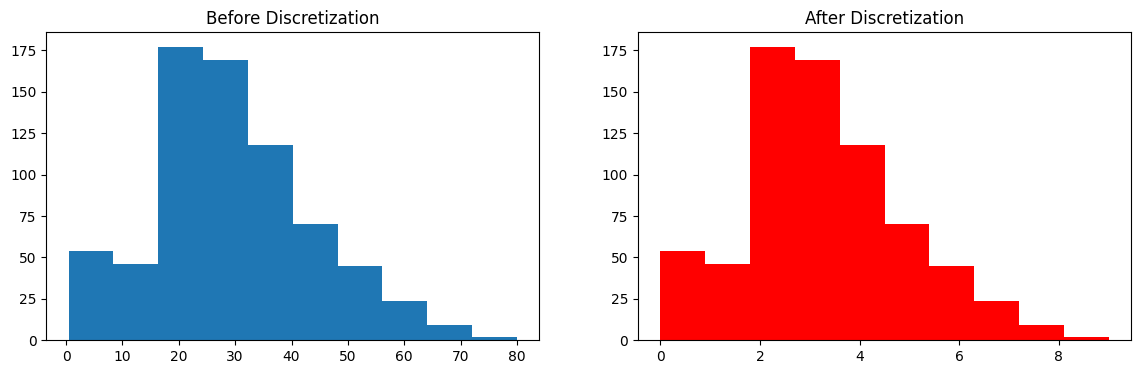

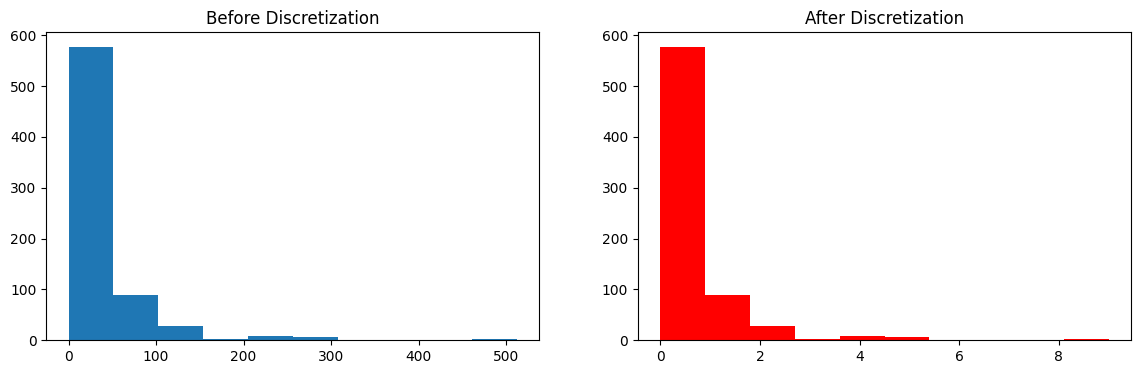

In [50]:
discretize(10, 'uniform')

Cross Validation Scores (All):  [0.59722222 0.59722222 0.625      0.66666667 0.5915493  0.73239437
 0.73239437 0.6056338  0.57746479 0.6056338 ]
Cross Validation Scores (Mean Value):  0.6372848200312988


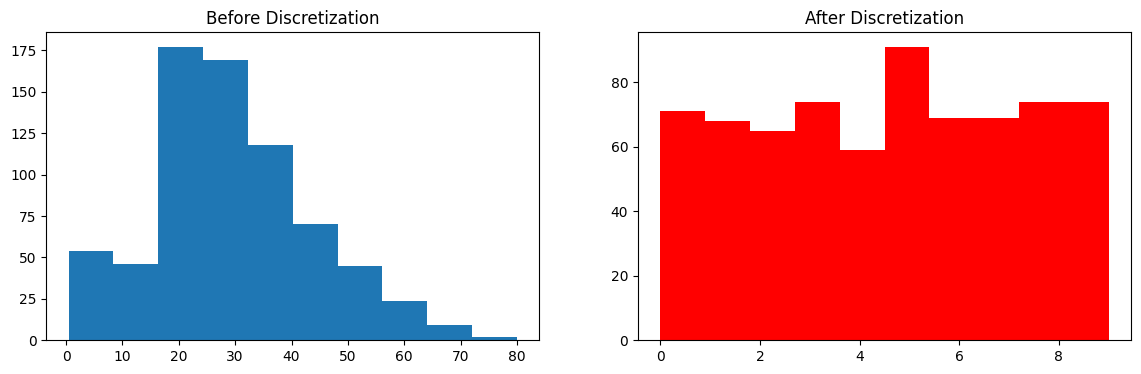

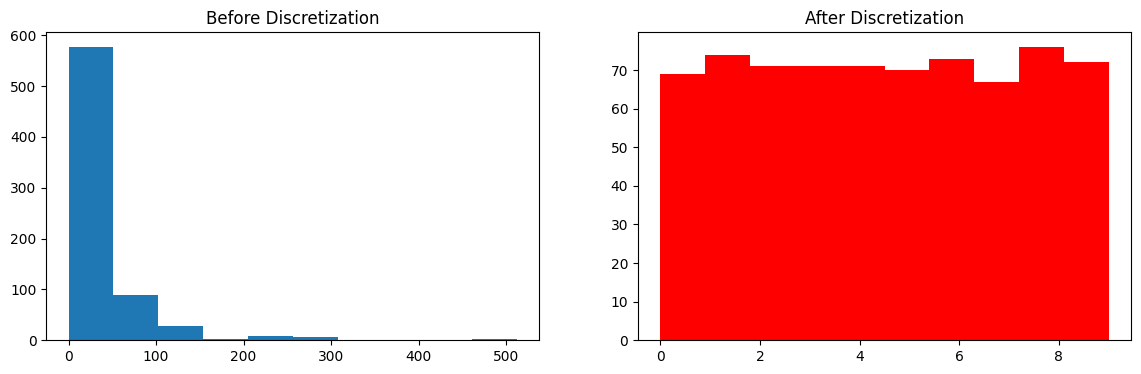

In [51]:
discretize(10, 'quantile')

Cross Validation Scores (All):  [0.59722222 0.59722222 0.625      0.66666667 0.57746479 0.71830986
 0.71830986 0.63380282 0.56338028 0.6056338 ]
Cross Validation Scores (Mean Value):  0.6316901408450704


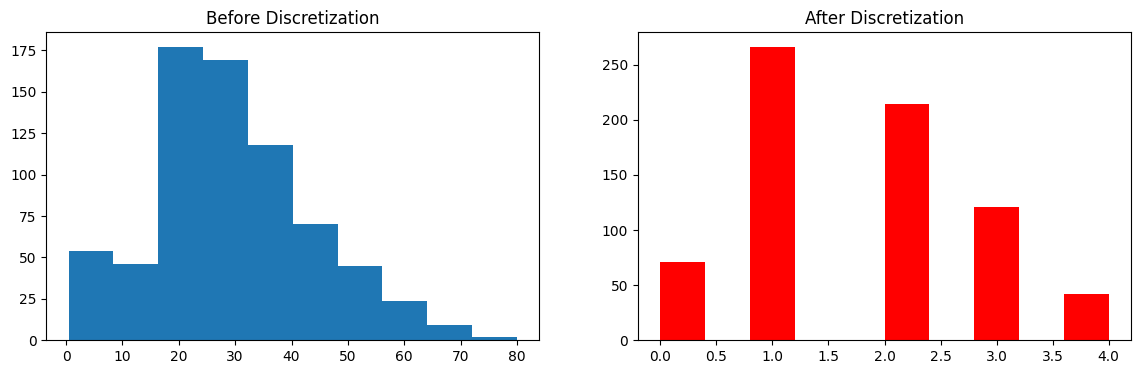

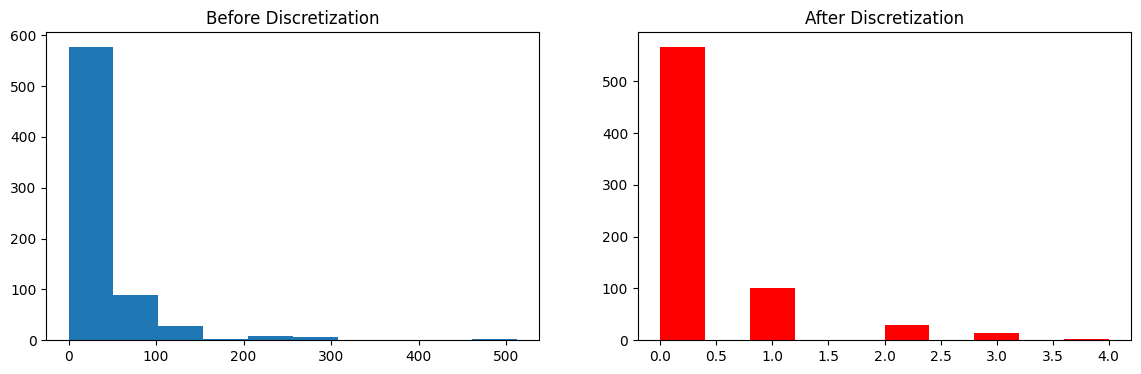

In [55]:
discretize(5, 'kmeans')

# BINARIZATION

## Importing Libraries

In [56]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer

## Loading Titanic Dataset

In [57]:
df = pd.read_csv('/content/train.csv')[['Age', 'Fare', 'SibSp', 'Parch', 'Survived']]

In [58]:
df.dropna(inplace = True)

In [59]:
df.head()

,Age,Fare,SibSp,Parch,Survived
0,22.0,7.2500,1,0,0
1,38.0,71.2833,1,0,1
2,26.0,7.9250,0,0,1
3,35.0,53.1000,1,0,1
4,35.0,8.0500,0,0,0


## Converting the `SibSp` and `Parch` as in one column called `Family`

[`SibSp` + `Parch` = `Family`]

In [61]:
df['Family'] = df['SibSp'] + df['Parch']

In [62]:
df.head()

,Age,Fare,SibSp,Parch,Survived,Family
0,22.0,7.2500,1,0,0,1
1,38.0,71.2833,1,0,1,1
2,26.0,7.9250,0,0,1,0
3,35.0,53.1000,1,0,1,1
4,35.0,8.0500,0,0,0,0


## Dropping the columns of `SibSp` and `Parch`

In [63]:
df = df.drop(columns = ['SibSp', 'Parch'])

In [64]:
df.head()

,Age,Fare,Survived,Family
0,22.0,7.2500,0,1
1,38.0,71.2833,1,1
2,26.0,7.9250,1,0
3,35.0,53.1000,1,1
4,35.0,8.0500,0,0


## Spliting the X and y as the variables


In [65]:
X = df.drop(columns = ['Survived'])
y = df['Survived']

## Train and Test Split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [67]:
X_train.head()

,Age,Fare,Family
328,31.0,20.5250,2
73,26.0,14.4542,1
253,30.0,16.1000,1
719,33.0,7.7750,0
666,25.0,13.0000,0


## Without Binarization

In [70]:
# Without Binarization
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy of Decision Tree (without using Binarization): ", accuracy_score(y_test, y_pred))

Accuracy of Decision Tree (without using Binarization):  0.6293706293706294


In [71]:
print("Cross Validation Score (without using Binarization): ", np.mean(cross_val_score(DecisionTreeClassifier(), X, y, cv = 10, scoring = 'accuracy')))

Cross Validation Score (without using Binarization):  0.6457550860719875


## After Binarization

In [72]:
# After Binarization
from sklearn.preprocessing import Binarizer

In [75]:
trf = ColumnTransformer([
    ('bin', Binarizer(copy = False), ['Family'])
], remainder = 'passthrough')

In [76]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [78]:
pd.DataFrame(X_train_trf, columns = ['Family', 'Age', 'Fare'])

,Family,Age,Fare
0,1.0,31.0,20.5250
1,1.0,26.0,14.4542
2,1.0,30.0,16.1000
3,0.0,33.0,7.7750
4,0.0,25.0,13.0000
...,...,...,...
566,1.0,46.0,61.1750
567,0.0,25.0,13.0000
568,0.0,41.0,134.5000
569,1.0,33.0,20.5250


Here, we are checking that if the person is travelling solo or with family, we have applied binarization on that.

- If he is with family then `1`
- If he is on solo trip then `0`

In [79]:
dt = DecisionTreeClassifier()
dt.fit(X_train_trf, y_train)
y_pred = dt.predict(X_test_trf)
print("Accuracy of Decision Tree (after using Binarization): ", accuracy_score(y_test, y_pred))

Accuracy of Decision Tree (after using Binarization):  0.6223776223776224


In [81]:
X_trf = trf.fit_transform(X)
print("Cross Validation (after using Binarization): ", np.mean(cross_val_score(DecisionTreeClassifier(), X_trf, y, cv = 10, scoring = 'accuracy')))

Cross Validation (after using Binarization):  0.6275821596244132
